In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import seaborn as sns

from src.network import Layer
from src.ou_process import ouprocess_gaussian
from src.experiment import Experiment

sns.set()

In [2]:
NUM_NEURONS = 1000 # 100
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
t_stop = 1.0e3 # 50.0e3

In [3]:
# Slow Signal: INPUT
input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
i_inj = 16.0 + 6.0*input_slow

In [4]:
layer = Layer(NUM_NEURONS)
layer.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop)
out, V, F_binary, F_synaptic = layer.output(i_inj, dt, t_stop)

C:\Users\Sayan Faraz\Documents\Projects\ReliableInfoTransfer\neural-learning\src\network.py:73: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.W, residuals, rank, s = np.linalg.lstsq(A, exp_output)


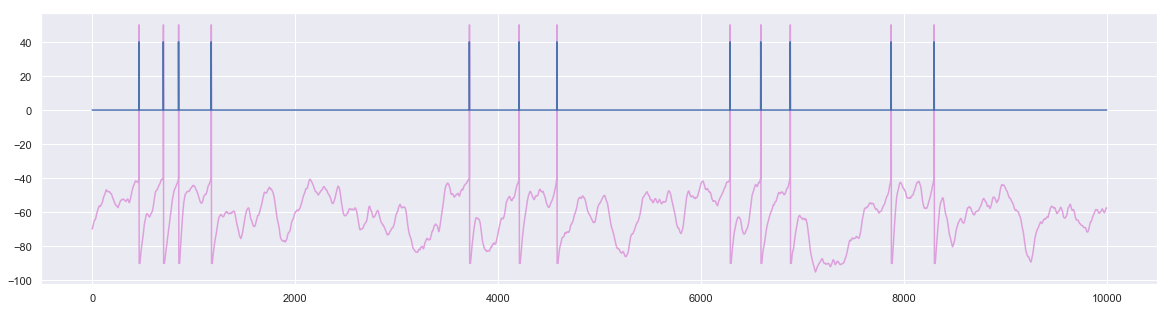

In [5]:
trial = 10
t_i = 0
t_f = -1
plt.figure(figsize=(20,5))
plt.plot(V[t_i:t_f,trial], color='plum')
plt.plot(F_binary[t_i:t_f,trial] * 40.0)
plt.show()

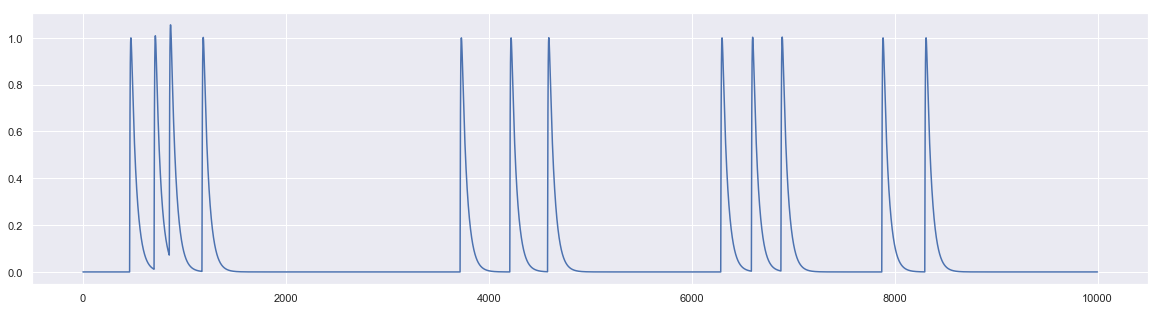

In [6]:
plt.figure(figsize=(20,5))
plt.plot(F_synaptic[:,10])

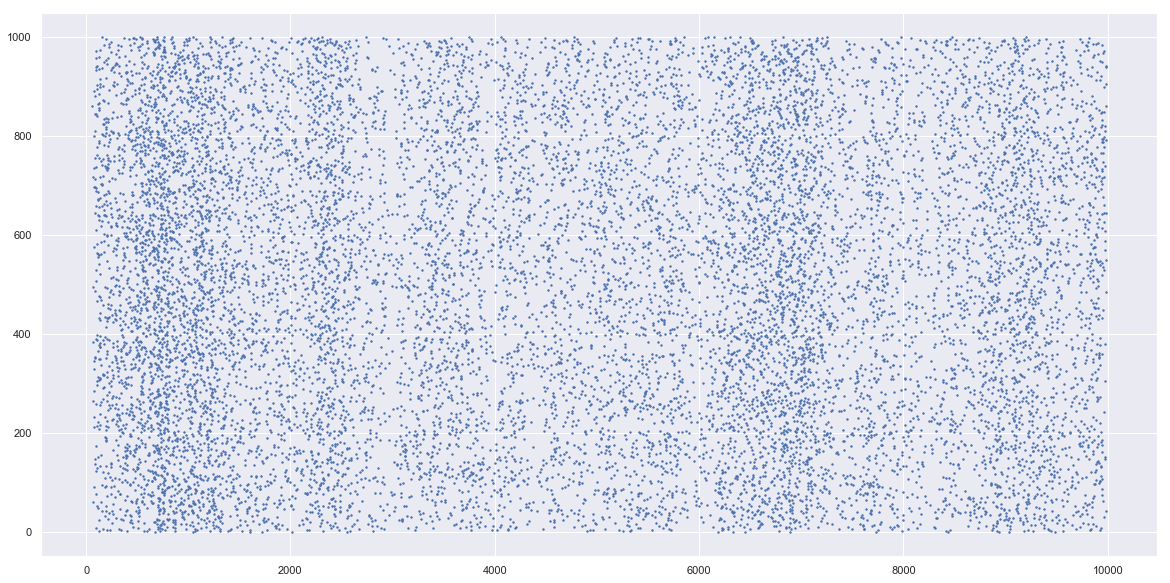

In [7]:
spike_inds, spike_trial = np.where(F_binary > 0)
plt.figure(figsize=(20,10))
plt.scatter(spike_inds, spike_trial, s=2)

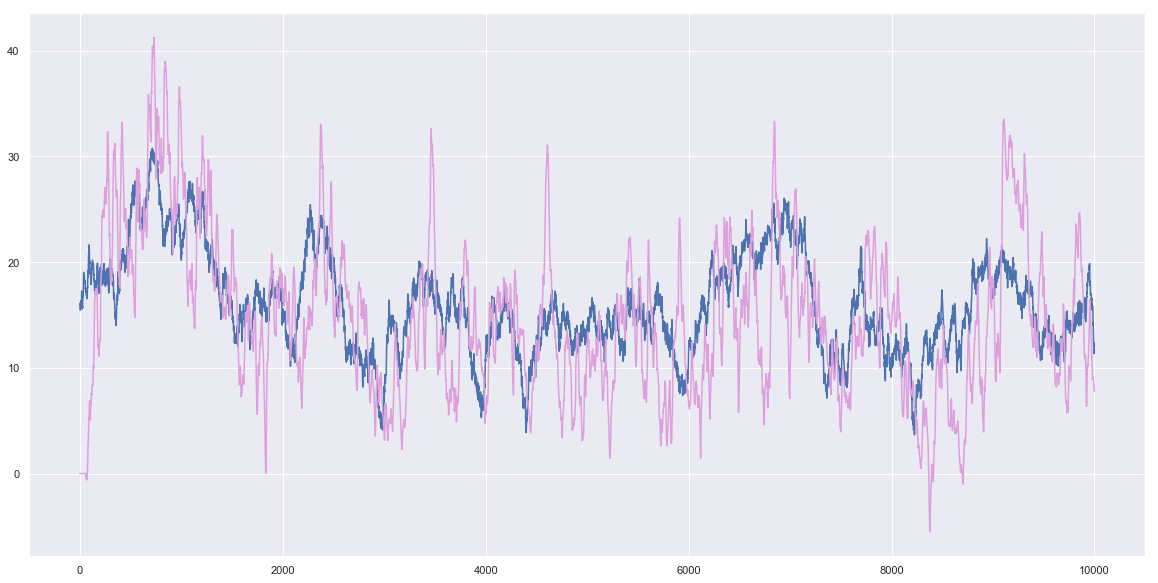

In [8]:
plt.figure(figsize=(20,10))
plt.plot(i_inj)
plt.plot(out, 'plum')

In [9]:
np.linalg.norm(out-i_inj)

635.0748243415171

In [14]:
NUM_TRIALS = 200

num_t = np.arange(0.0, t_stop, dt).shape[0]
inputs = np.empty((num_t, NUM_TRIALS))

for i in range(NUM_TRIALS):
    input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
    i_inj = 16.0 + 6.0*input_slow
    inputs[:,i] = i_inj.flatten()

In [15]:
experiment = Experiment(inputs, layer, NUM_TRIALS, dt, t_stop)
spikes = experiment.run()
with open("1000_neurons_200_trials_input=tau_50_regenerated.pkl", 'wb') as pickle_out:  
    pickle.dump(experiment, pickle_out)

Trial  0
10 Iter time:  7.345417499542236
Total time:  7.345417499542236


Trial  10
10 Iter time:  67.0046284198761
Total time:  74.35206365585327


Trial  20
10 Iter time:  56.111140966415405
Total time:  130.46523809432983


Trial  30
10 Iter time:  55.22391319274902
Total time:  185.68915128707886


Trial  40
10 Iter time:  57.48675990104675
Total time:  243.17891240119934


Trial  50
10 Iter time:  54.86735153198242
Total time:  298.048259973526


Trial  60
10 Iter time:  58.12458395957947
Total time:  356.1748435497284


Trial  70
10 Iter time:  59.15019989013672
Total time:  415.33310437202454


Trial  80
10 Iter time:  56.18012022972107
Total time:  471.5132246017456


Trial  90
10 Iter time:  56.92075157165527
Total time:  528.4339761734009


Trial  100
10 Iter time:  55.93063473701477
Total time:  584.3646109104156


Trial  110
10 Iter time:  55.352949142456055
Total time:  639.7185573577881


Trial  120
10 Iter time:  56.35597229003906
Total time:  696.0765287876129


Trial 

In [16]:
l2_norms = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    l2_norms[i] = np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])

(array([ 5.,  3.,  8., 11., 25., 23., 18., 36., 33., 10., 11.,  5.,  6.,
         3.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([527.00547507, 543.49778013, 559.99008519, 576.48239026,
        592.97469532, 609.46700038, 625.95930544, 642.45161051,
        658.94391557, 675.43622063, 691.92852569, 708.42083076,
        724.91313582, 741.40544088, 757.89774595, 774.39005101,
        790.88235607, 807.37466113, 823.8669662 , 840.35927126,
        856.85157632]),
 <a list of 20 Patch objects>)

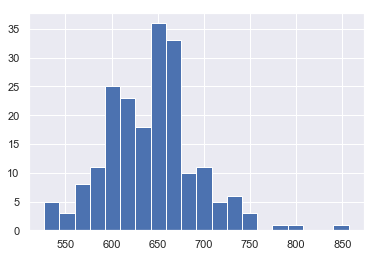

In [18]:
plt.hist(l2_norms, bins=20)

{'whiskers': [<matplotlib.lines.Line2D at 0x20a88748c88>,
 'caps': [<matplotlib.lines.Line2D at 0x20a887553c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x20a88748b00>],
 'medians': [<matplotlib.lines.Line2D at 0x20a88755ac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x20a88755e48>],
 'means': []}

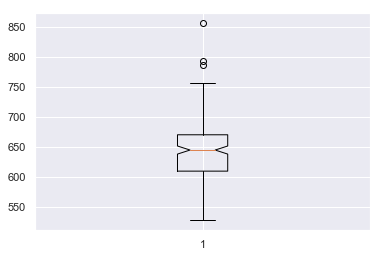

In [19]:
plt.boxplot(l2_norms, notch=True, sym="o")

In [ ]:
# EXPERIMENT 2: Shuffle weights, how does this affect reconstruction?


In [ ]:
# EXPERIMENT 3: Sweep Tau = 30--50
NUM_TRIALS = 200

num_t = np.arange(0.0, t_stop, dt).shape[0]
inputs = np.empty((num_t, NUM_TRIALS))

for i in range(NUM_TRIALS):
    input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
    i_inj = 16.0 + 6.0*input_slow
    inputs[:,i] = i_inj.flatten()